In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, \
                            classification_report, precision_recall_curve, log_loss
from sklearn import metrics

import imblearn.over_sampling

In [2]:
%store -r weather_feature_sel

In [3]:
weather_feature_sel.head()

,Evaporation,Cloud3pm,WindGustSpeed,WindSpeed9am,Humidity3pm,Temp9am,Sunshine,Month_Name,Location,RainTomorrow
6049,12.0,5.0,48.0,6.000000,13.0,26.600000,12.3,Jan,Cobar,No
6050,14.8,1.0,37.0,19.000000,8.0,20.300000,13.0,Jan,Cobar,No
6051,12.6,1.0,30.0,14.636516,7.0,18.084507,13.3,Jan,Cobar,No
6052,10.8,6.0,46.0,30.000000,22.0,28.700000,10.6,Jan,Cobar,No
6053,11.4,5.0,31.0,6.000000,22.0,29.100000,12.2,Jan,Cobar,No


In [4]:
from sklearn.preprocessing import LabelEncoder
  
le = LabelEncoder()
  
weather_feature_sel['RainTomorrow']= le.fit_transform(weather_feature_sel['RainTomorrow'])

## Dummy Encoding Categorical Variables


In [5]:
weather_feature_sel = pd.get_dummies(data=weather_feature_sel, columns=['Month_Name', 'Location'])

In [6]:
weather_feature_sel = weather_feature_sel [['Evaporation', 'Cloud3pm', 'WindGustSpeed', 'WindSpeed9am',
       'Humidity3pm', 'Temp9am', 'Sunshine', 'Month_Name_Apr',
       'Month_Name_Aug', 'Month_Name_Dec', 'Month_Name_Feb', 'Month_Name_Jan',
       'Month_Name_Jul', 'Month_Name_Jun', 'Month_Name_Mar', 'Month_Name_May',
       'Month_Name_Nov', 'Month_Name_Oct', 'Month_Name_Sep',
       'Location_Adelaide', 'Location_Albany', 'Location_Albury',
       'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat',
       'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns',
       'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour',
       'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast',
       'Location_Hobart', 'Location_Katherine', 'Location_Launceston',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura',
       'Location_Moree', 'Location_MountGambier', 'Location_MountGinini',
       'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead',
       'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF',
       'Location_Penrith', 'Location_Perth', 'Location_PerthAirport',
       'Location_Portland', 'Location_Richmond', 'Location_Sale',
       'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport',
       'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru',
       'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia',
       'Location_Williamtown', 'Location_Witchcliffe', 'Location_Wollongong',
       'Location_Woomera','RainTomorrow']]

In [7]:
X = weather_feature_sel.iloc[:, :68]
y = weather_feature_sel['RainTomorrow']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify = y_train) 

In [10]:
ROS = imblearn.over_sampling.RandomOverSampler( random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_train, y_train)

In [11]:
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(X_tr_rs, y_tr_rs)

RandomForestClassifier()

In [12]:
#y_train_pred = randomforest.predict(X_tr_rs)
y_val_pred = randomforest.predict(X_val)

In [13]:
accuracy = metrics.accuracy_score(y_val, y_val_pred)
precision = metrics.precision_score(y_val, y_val_pred)
recall = metrics.recall_score(y_val, y_val_pred)
f1 = metrics.f1_score(y_val, y_val_pred)

print("Val Set Accuracy:" , round(accuracy, 3))
print("Val Set Precision:", round(precision, 3))
print("Val Set Recall:", round(recall, 3))
print("Val Set F1 Score:", round(f1, 3))

Val Set Accuracy: 0.845
Val Set Precision: 0.686
Val Set Recall: 0.568
Val Set F1 Score: 0.621


## Setting Threshold

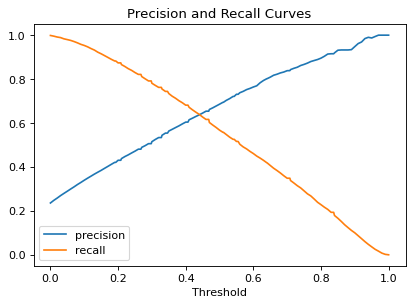

In [14]:
precision_curve, recall_curve, threshold_curve = \
        precision_recall_curve(y_val, randomforest.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

In [15]:
def make_confusion_matrix(model, threshold=0.4):
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    rain_matrix = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=120)
    sns.heatmap(rain_matrix, cmap=plt.cm.Reds, annot=True, square=True, fmt='d',
           xticklabels=['Rain', 'No Rain'],
           yticklabels=['Rain', 'No Rain']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88     22063
           1       0.60      0.69      0.64      6376

    accuracy                           0.83     28439
   macro avg       0.75      0.78      0.76     28439
weighted avg       0.84      0.83      0.83     28439



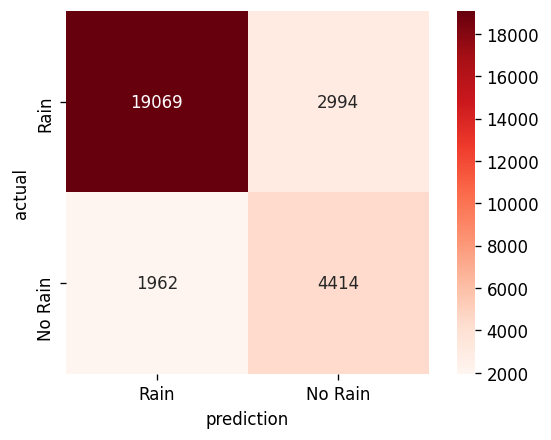

In [16]:
make_confusion_matrix(randomforest)


In [17]:
fpr, tpr, thresholds = roc_curve(y_val, randomforest.predict_proba(X_val)[:,1])


ROC AUC score =  0.8699005779957939


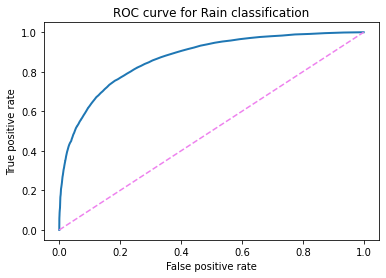

In [18]:
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Rain classification');

print("ROC AUC score = ", roc_auc_score(y_val, randomforest.predict_proba(X_val)[:,1]))

In [19]:
print("Log-loss on random forest: {:6.4f}".format(log_loss(y_val, randomforest.predict_proba(X_val))))


Log-loss on random forest: 0.3694


## Gridsearch for hyperparameter tuning

In [20]:
from sklearn.model_selection import GridSearchCV


We can get a best accuracy of 0.9441238588741753 using {'max_depth': 35}


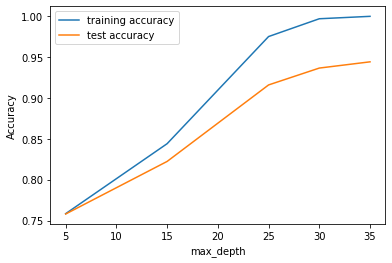

We can get a best accuracy of 0.9489080450761913 using {'min_samples_leaf': 1}


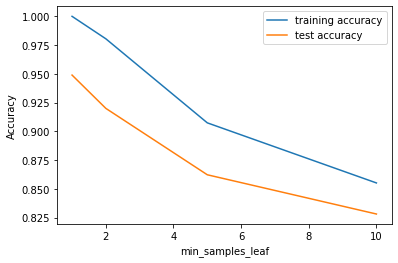

We can get a best accuracy of 0.949234521264102 using {'min_samples_split': 2}


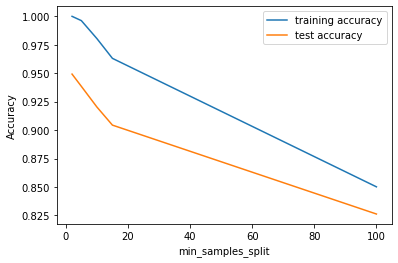

We can get a best accuracy of 0.9490593733639621 using {'n_estimators': 800}


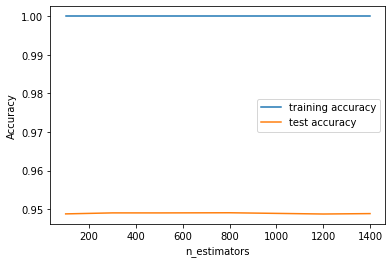

In [21]:
# specify number of folds for k-fold CV
n_folds = 5

hyperparameter=['max_depth', 'min_samples_leaf','min_samples_split','n_estimators']

range  =[ 
         [5, 15, 25, 30, 35],
         [1, 2, 5, 10],
         [2, 5, 10, 15, 100],
         [100, 300, 500, 800, 1200, 1400], 
         
]
        
    
for var in zip(hyperparameter,range):
    
    parameters = {"{}".format(var[0]): var[1]}
    # instantiate the model
    randomforest1 = RandomForestClassifier()

    # fit grid_search on training data
    grid_search = GridSearchCV(randomforest1, parameters,
                        cv=n_folds,
                       scoring="f1",
                     return_train_score=True)
    grid_search.fit(X_tr_rs, y_tr_rs)
    scores = grid_search.cv_results_
    print('We can get a best accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

    plt.figure()
    plt.plot(scores['param_'+var[0]], 
             scores["mean_train_score"], 
             label="training accuracy")
    plt.plot(scores['param_'+var[0]], 
             scores["mean_test_score"], 
             label="test accuracy")
    plt.xlabel(var[0])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

#### the parameter value with the highest test score is the best one, you have to also see if the accuracy stays stable.

## Model with Best Hyperparameters

In [22]:
# model with the best hyperparameters
rf_best = RandomForestClassifier(bootstrap=True,
                             max_depth=35,
                             min_samples_leaf=1, 
                             min_samples_split=2,
                             n_estimators=800)

In [23]:
rf_best.fit(X_tr_rs, y_tr_rs)

RandomForestClassifier(max_depth=35, n_estimators=800)

In [24]:
y_test_pred = randomforest.predict(X_test)

In [25]:
accuracy = metrics.accuracy_score(y_test, y_test_pred)
precision = metrics.precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
f1 = metrics.f1_score(y_test, y_test_pred)

print("Test Set Accuracy:" , round(accuracy, 3))
print("Test Set Precision:", round(precision, 3))
print("Test Set Recall:", round(recall, 3))
print("Test Set F1 Score:", round(f1, 3))

Test Set Accuracy: 0.843
Test Set Precision: 0.679
Test Set Recall: 0.571
Test Set F1 Score: 0.62


In [26]:
def make_confusion_matrix(model, threshold=0.4):
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    rain_matrix = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=150)
    sns.heatmap(rain_matrix, cmap=plt.cm.Reds, annot=True, square=True, fmt='d',
           xticklabels=['Rain', 'No Rain'],
           yticklabels=['Rain', 'No Rain']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88     22064
           1       0.58      0.71      0.64      6375

    accuracy                           0.82     28439
   macro avg       0.74      0.78      0.76     28439
weighted avg       0.84      0.82      0.83     28439



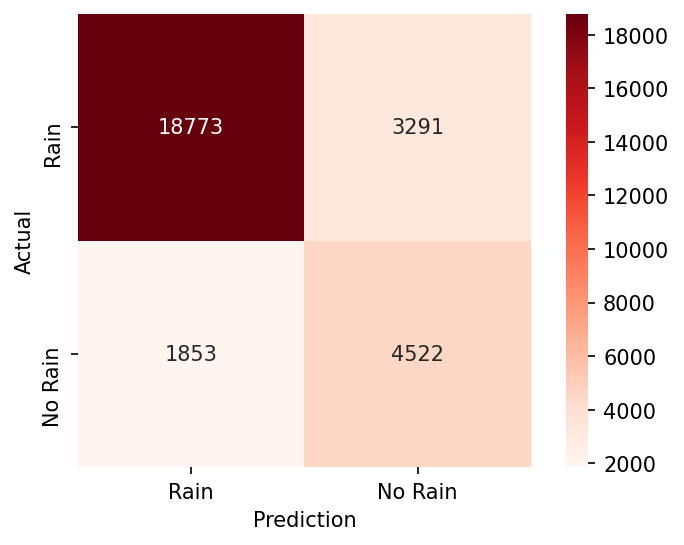

In [27]:
make_confusion_matrix(rf_best)


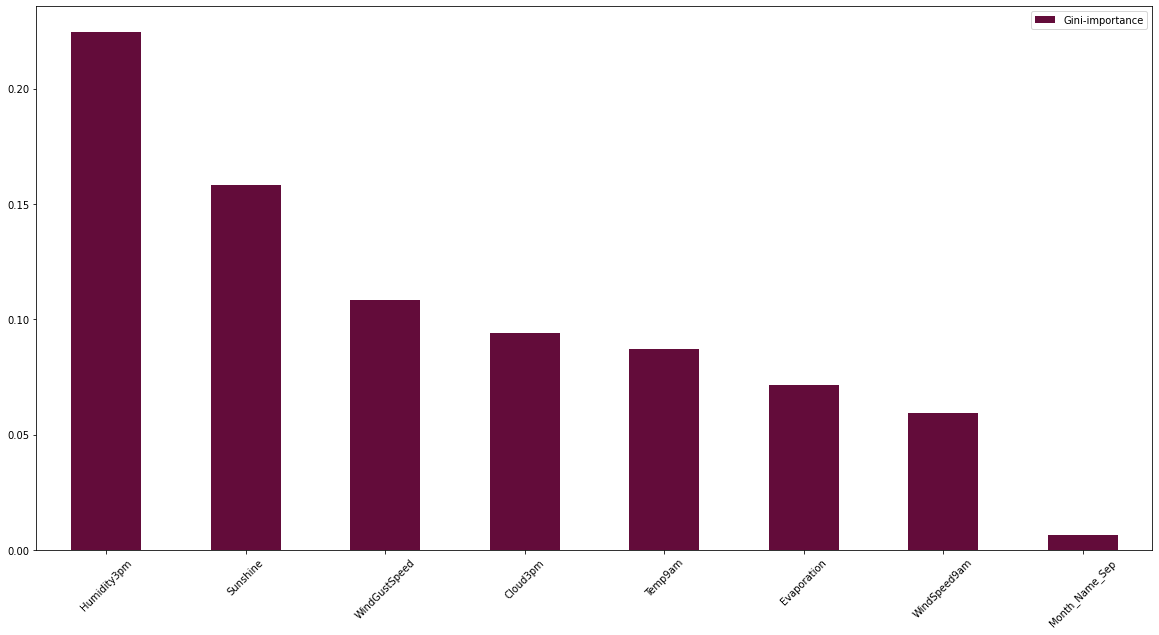

In [28]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_test.columns, rf_best.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending =False).head(8).plot(kind='bar', rot=45, figsize=(20,10));